In [5]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from scipy.ndimage import morphology

import get_halpha_SB

%matplotlib inline

machine = 'coho'

In [6]:
if machine == 'chinook':
    homedir = '/Users/lokhorst/Desktop/PipelineTesting/'
if machine == 'coho':
    homedir = '/Users/deblokhorst/Desktop/tmp/'


In [7]:
def plotdata(data,ax=None,bounds=None,colorbar=False):
    if ax is None:
        fig = plt.figure(figsize=(6, 3.2))
        ax = fig.add_subplot(111)
        oneplot=True
    if bounds is None:
        img = ax.imshow(data,origin='lower',interpolation='nearest')
    else:
        img = ax.imshow(data,origin='lower',vmin=bounds[0],vmax=bounds[1],interpolation='nearest')
    ax.set_aspect('equal')
    
    if colorbar:
        div = axgrid.make_axes_locatable(ax)
        cax = div.append_axes("right",size="10%",pad=0.15)
        cbar = plt.colorbar(img,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
        cbar.ax.tick_params()

In [42]:
def imreduce_masked(img,factor,log=True,fillby='max'):
    """
    reduces the resolution of an image by taking the mean of individual elements
    takes in a mask to mask out values to be not included in the mean
        img: 2D image array
        mask: mask for the 2D image array
        factor: factor by which to reduce the number of array elements along each axis
    examples:
    for testing: 
        image = np.array([[1,1,2,2],[1,201,2,2],[3,3,200,4],[3,3,4,4]])
    mask your mask like this:  
        clipped = sigma_clip(image,sig=3,iters=2)
        mask = clipped.mask
    """
    inimg = img
    
    if log:
        inimg = 10**img
    
    inshape = np.array(img.shape)
    
    clipped_full = sigma_clip(inimg,sig=3,iters=5)
    outliers =clipped_full.mask
    # grow the mask
    outliers =morphology.grey_dilation(outliers,(3,3))       # the mask
    print outliers
    
    #### XXX save the mask
    inmask = outliers
    
    if np.sum(inshape%factor) != 0:
        print('Output grid must have a integer number of cells: cannot reduce image pixels by a factor %i'%factor)
        return None

    # split along axes into groups that will be binned
    inimg = np.array(np.split(inimg,inshape[0]/factor,axis=0))
    inimg = np.array(np.split(inimg,inshape[1]/factor,axis=-1))
    # do the same for the masks
    inmask = np.array(np.split(inmask,inshape[0]/factor,axis=0))
    inmask = np.array(np.split(inmask,inshape[1]/factor,axis=-1))
    
    # make the masked array
    x = np.ma.array(inimg, mask=inmask)
       
    # take the mean along different axes
    x = np.ma.mean(x,axis=-1)
    x = np.ma.mean(x,axis=-1)
    
    # BUT WHAT IF THERE IS ONLY MASKED DATA WITHIN A BIN...
    fillvalue=fillby
    if True in x.mask:
        print "WARNING: At least one bin contains only masked data - will be filled to %s."%fillby
        if fillby=='mean':
            x = x.filled(x.mean())
            fillvalue= x.mean()
        elif fillby=='max':
            x = x.filled(x.max())
            fillvalue=x.max()
        else:
            x = x.filled(fillvalue)
            
        return x.T,outliers,fillvalue

    outimg = x.data
    
    return outimg.T, outliers, fillvalue

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


Binning the data down to about 150 arcsec scale, so using a factor of 50.0.
[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]
 [False False False ..., False False False]]


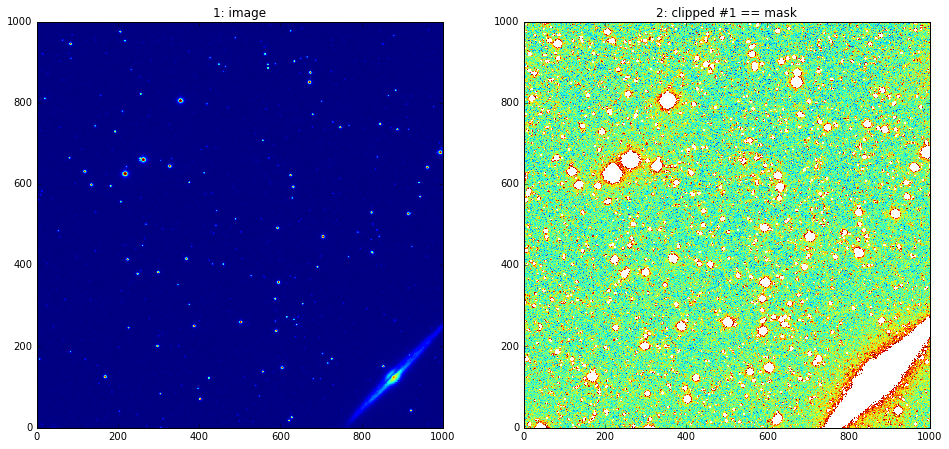

In [43]:

imagefile=homedir+'2017-04-02_coadd_SloanG.fits'
d_needle279,h_needle279 = fits.getdata(imagefile,header=True)

image = d_needle279
scale = 150 # arcsec
pixelscale = 3.0 #arcsec per pixel
factor = scale/pixelscale
img = image[40*factor:60*factor,40*factor:60*factor]     # the data

clipped_full = sigma_clip(img,sig=3,iters=5)
outliers =clipped_full.mask
# grow the mask
outliers =morphology.grey_dilation(outliers,(3,3))       # the mask
print "Binning the data down to about %s arcsec scale, so using a factor of %s." %(scale,factor)

# Plot the full res data and mask of that
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
plotdata(np.log10(img),ax=ax1)
ax1.set_title('1: image')
plotdata(np.log10(clipped_full),ax=ax2)
ax2.set_title('2: clipped #1 == mask')

# Plot the binned data (wo mask) and binned data (w mask)
lowres = get_halpha_SB.imreduce(img, factor, log=False, method = 'average') 
lowres_masked, mask, fillvalue = imreduce_masked(img,factor,log=False)